<a href="https://colab.research.google.com/github/Investigator13th/CS246/blob/main/CS246_Colab_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS246 - Colab 6
## node2vec

### Setup

First of all, we install the [graph2vec library](https://github.com/VHRanger/graph2vec) which offers a fast implementation of the node2vec method.

If you are curious to learn how to implement fast random walks on graphs, I recommend you to [read the blog post](https://www.singlelunch.com/2019/08/01/700x-faster-node2vec-models-fastest-random-walks-on-a-graph/) which explains some of the design choices behind this library.

In [1]:
!python -m pip install 'csrgraph @ git+https://github.com/VHRanger/CSRGraph@f052c1cf128ab21d21a4710337dc7c1cd5658df7'
!python -m pip install 'nodevectors @ git+https://github.com/aman0456/nodevectors@67e9af0506236be9aae6d460e96d4dec6329bcd2'

  Cloning https://github.com/VHRanger/CSRGraph (to revision f052c1cf128ab21d21a4710337dc7c1cd5658df7) to /tmp/pip-install-ehd5j_hl/csrgraph_006cd62a8a934de5804244f7b9722928
  Running command git clone --filter=blob:none --quiet https://github.com/VHRanger/CSRGraph /tmp/pip-install-ehd5j_hl/csrgraph_006cd62a8a934de5804244f7b9722928
  Running command git rev-parse -q --verify 'sha^f052c1cf128ab21d21a4710337dc7c1cd5658df7'
  Running command git fetch -q https://github.com/VHRanger/CSRGraph f052c1cf128ab21d21a4710337dc7c1cd5658df7
  Running command git checkout -q f052c1cf128ab21d21a4710337dc7c1cd5658df7
  Resolved https://github.com/VHRanger/CSRGraph to commit f052c1cf128ab21d21a4710337dc7c1cd5658df7
  Preparing metadata (setup.py) ... done
  Created wheel for csrgraph: filename=csrgraph-0.1.29-py3-none-any.whl size=19406 sha256=1c7dceeaf5c4050cc3ec025b80196a9b988da28fe3f07ce242e7ec7d5d5a311f
  Stored in directory: /root/.cache/pip/wheels/9b/b2/53/46e2e64492e0bdfaab6d5eb9d1c147dcaa8f883bc

# We now import the library, and create a small wrapper class which will expose only the few hyperparameters we will need to tune in this Colab

In [2]:
from nodevectors import Node2Vec
import networkx as nx

class Node2VecNew(Node2Vec):
  """
  Parameters
  ----------
  p : float
      p parameter of node2vec
  q : float
      q parameter of node2vec
  d : int
      dimensionality of the embedding vectors
  """
  def __init__(self, p=1, q=1, d=32):
    super().__init__(
                 n_components=d,
                     walklen=10,
                     epochs=50,
                     return_weight=1.0/p,
                     neighbor_weight=1.0/q,
                     threads=0,
                     w2vparams={'window': 4,
                                'negative': 5,
                                'iter': 10,
                                'ns_exponent': 0.5,
                                'batch_words': 128})

Lastly, let's import some of the common libraries needed for our task.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

### Example

In the example below, we will try to reproduce the plot in slide 8 of [CS246 - Lecture 12](https://web.stanford.edu/class/cs246/slides/13-graphemb.pdf).

In [24]:
# Load the Zachary's Karate Club as a NetworkX Graph object
KCG = nx.karate_club_graph()

# Fit embedding model to the Karate Club graph
n2v = Node2VecNew(0.5, 1, 2)
n2v.fit(KCG)

Making walks... Done, T=0.05
Mapping Walk Names... Done, T=0.03
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=0.39


In [25]:
embeddings = []
for node in KCG.nodes:
  embedding = list(n2v.predict(node))
  club = KCG.nodes[node]['club']
  embeddings.append(embedding + [club])

# Construct a pandas dataframe with the 2D embeddings from node2vec,
# plus the club name that each node belongs to after the split
df = pd.DataFrame(embeddings, columns=['x', 'y', 'club'])

<Axes: xlabel='x', ylabel='y'>

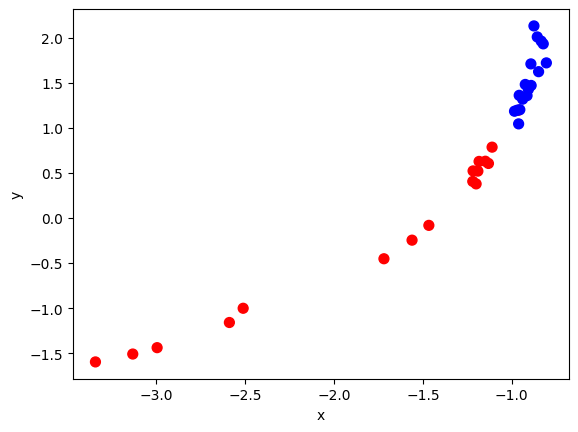

In [26]:
# Nodes who stayed with the Mr. Hi will be plotted in red, while nodes
# who moved with the Officer will be plotted in blue
colors = ['red' if x == 'Mr. Hi' else 'blue' for x in df.club]
df.plot.scatter(x='x', y='y', s=50, c=colors)

If our example trained correctly, you should notice a clear separation between the blue and red nodes.  Solely from the graph structure, node2vec could predict how the Zachary's Karate Club split!

Tune the hyperparameters ```p``` and ```q```, and notice how they affect the resulting embeddings.

### Your Task

Now we will study the behavior of node2vec on [barbell graphs](https://en.wikipedia.org/wiki/Barbell_graph).

Below you can see a toy example of a barbell graph generated with NetworkX.

In [29]:
toy_barbell = nx.barbell_graph(500, 0)

Generate a larger barbell graph, where each complete graph has exactly 1000 nodes.

Then, learn node2vec embeddings on this graph, setting ```p = 1, q = 1``` and ```d = 10```.

In [32]:
''' 5-7 lines of code in total expected but can differ based on your style.
For sub-parts of the question (if any), creating different cells of code would be recommended.'''
# YOUR CODE HERE
n2v = Node2VecNew(1, 1, 10)
n2v.fit(toy_barbell)

Making walks... Done, T=0.27
Mapping Walk Names... Done, T=0.50
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=14.54


In [35]:
embeddings = {}
for node in toy_barbell.nodes:
  embeddings[node] = n2v.predict(node)

In [42]:
embeddings[5]

array([ 0.7076174 ,  0.2514424 , -0.60530657, -1.4037501 ,  1.0295442 ,
       -0.90067476, -0.30754063,  0.97801924,  0.6752103 , -0.6840726 ],
      dtype=float32)

Write a function that takes as input a node id ```n``` in the graph (e.g., ```5```) and returns a list containining the cosine similarity between the node2vec vector of the input node ```n``` and all the nodes in the given barbell graph (including the similarity with ```n``` itself).

In [44]:
''' 24-30 lines of code in total expected but can differ based on your style.
For sub-parts of the question (if any), creating different cells of code would be recommended.'''

# YOUR CODE HERE
def cosine_similarity(vec1, vec2):

    dot_product = np.dot(vec1, vec2)

    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)

    if norm_vec1 == 0 or norm_vec2 == 0:
        return 0

    return dot_product / (norm_vec1 * norm_vec2)


def n2vector_cos_sim(embeddings, id):
  cos_sim = []
  embedding = embeddings[id]

  for _,v in embeddings.items():
    cos_sim.append(cosine_similarity(embedding, v))

  return [embedding, cos_sim]

In [45]:
res = n2vector_cos_sim(embeddings, 5)

In [46]:
res[1][5]

1.0

Generate another barbell graph, this time adding a path of length 51 between

---

the two complete graphs. To find out how, refer to the NetworkX documentation: [https://networkx.github.io/documentation/stable/reference/

---

generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.classic.barbell_graph.html#networkx.generators.classic.barbell_graph)

Learn the node2vec embeddings for the nodes of this new graph, using the same hyperparameters as before.

In [53]:
''' 10-12 lines of code in total expected but can differ based on your style.
For sub-parts of the question (if any), creating different cells of code would be recommended.'''
# YOUR CODE HERE
toy_barbell_new = nx.barbell_graph(500, 51)

Once you have working code for each cell above, **head over to Gradescope, read carefully the questions, and submit your solution for this Colab**!


In [54]:
n2v = Node2VecNew(1, 1, 10)
n2v.fit(toy_barbell)

Making walks... Done, T=0.28
Mapping Walk Names... Done, T=0.35
Training W2V... WARNING: gensim word2vec version is unoptimizedTry version 3.6 if on windows, versions 3.7 and 3.8 have had issues
Done, T=11.76


In [55]:
embeddings = {}
for node in toy_barbell.nodes:
  embeddings[node] = n2v.predict(node)